###  Importation des bibliothèque 

In [1]:
import requests 
from requests.auth import HTTPBasicAuth
import json 
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Set API déja donnée

In [2]:
api_key = "cfbaf0e4-342b-4100-be55-d56d4aac6669"
server_url = 'https://esgf-server-staging.herokuapp.com'
service_name = 'get_inference_data'
params = f"?api_key={api_key}"
headers = {
       'Accept': 'application/json',
       'Authorization' : f"Bearer {api_key}"
}
response = requests.get(f"{server_url}/{service_name}{params}", headers=headers)
print(response.text)
assert response.status_code == 200

{"id":"FMVnkwoFEuuo9GkN","x":"{\"wconfid\":{\"0\":3,\"1\":3,\"2\":3,\"3\":3,\"4\":3,\"5\":3,\"6\":3,\"7\":3,\"8\":3,\"9\":3,\"10\":3,\"11\":3,\"12\":3,\"13\":3,\"14\":3,\"15\":3,\"16\":3,\"17\":3,\"18\":3,\"19\":3,\"20\":3,\"21\":3,\"22\":3,\"23\":3,\"24\":3,\"25\":3,\"26\":3,\"27\":3,\"28\":3,\"29\":3,\"30\":3,\"31\":3},\"pctid\":{\"0\":25,\"1\":25,\"2\":25,\"3\":25,\"4\":25,\"5\":25,\"6\":25,\"7\":25,\"8\":25,\"9\":25,\"10\":25,\"11\":25,\"12\":25,\"13\":25,\"14\":25,\"15\":25,\"16\":25,\"17\":25,\"18\":25,\"19\":25,\"20\":25,\"21\":25,\"22\":25,\"23\":25,\"24\":25,\"25\":25,\"26\":25,\"27\":25,\"28\":25,\"29\":25,\"30\":25,\"31\":25},\"x\":{\"0\":0.996,\"1\":1.023,\"2\":0.98,\"3\":0.992,\"4\":0.969,\"5\":1.016,\"6\":0.98,\"7\":0.984,\"8\":0.996,\"9\":0.988,\"10\":0.984,\"11\":1.02,\"12\":0.996,\"13\":0.98,\"14\":1.016,\"15\":0.988,\"16\":0.984,\"17\":1.027,\"18\":0.984,\"19\":1.012,\"20\":1.02,\"21\":0.977,\"22\":0.996,\"23\":0.973,\"24\":1.0,\"25\":1.004,\"26\":0.98,\"27\":1.0,\"28

In [6]:
# Réponse du serveur en json. Dictionnaire avec les clés 'id' et 'x'.
json_answer = response.json()

# Example id
example_id = json_answer['id']

# Analyse la réponse en tant qu'objet json
json_answer = json.loads(json_answer['x'])

df = pd.DataFrame(json_answer)

print("Sample ID='{}' has shape {}".format(example_id, pd_sample.shape))

Sample ID='FMVnkwoFEuuo9GkN' has shape (32, 5)


In [8]:
df.head()
df.tail()

,wconfid,pctid,x,y,z
27,3,25,1.000,0.055,-0.133
28,3,25,0.980,0.152,-0.160
29,3,25,1.020,0.074,-0.113
30,3,25,0.988,-0.043,-0.164
31,3,25,1.004,-0.020,-0.102


In [10]:
data = pd_sample[['x','y','z']]
print(data.shape)

(32, 3)


In [11]:
# repartition train et test
train_df=data[:-12]
test_df=data[-12:]

In [12]:
# Model
model = VAR(train_df.diff()[1:])
sorted_order=model.select_order(maxlags=3)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -18.90      -18.76   6.185e-09      -18.89
1      -21.93      -21.35   3.104e-10      -21.90
2      -21.83      -20.82   4.000e-10      -21.78
3     -23.60*     -22.15*  1.079e-10*     -23.52*
-------------------------------------------------


# vue globale sur l'interpretation des critéres 
. Comment interpréter  ?

. AIC : 

        Interprétation Le critère AIC représente donc un compromis entre le biais, diminuant avec le nombre de paramètres libres, et la parcimonie, volonté de décrire les données avec le plus petit nombre de  paramètres possibles.

. BIC :

    Le Bayesian information criterion BIC est défini par : BIC = −2 log(˜L) + k log(n). Il est plus parcimonieux que le critère AIC puisqu'il pénalise plus le nombre de variables présentent de le modèle.





In [13]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                           Statespace Model Results                           
Dep. Variable:        ['x', 'y', 'z']   No. Observations:                   20
Model:                         VAR(4)   Log Likelihood                 152.620
                          + intercept   AIC                           -215.241
Date:                Sun, 26 Feb 2023   BIC                           -170.433
Time:                        22:35:37   HQIC                          -206.494
Sample:                             0                                         
                                 - 20                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):       0.02, 1.54, 3.49   Jarque-Bera (JB):    8.62, 0.72, 34.03
Prob(Q):                  0.90, 0.21, 0.06   Prob(JB):             0.01, 0.70, 0.00
Heteroskedasticity (H):   0.28, 0.79, 0.06   Skew:                -0.36, 0.40, 1.33
Prob(H) (two-sided):      0.12, 0.76,

In [15]:
n_forecast = 600
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)
predictions=predict.predicted_mean

In [16]:
predictions.columns=['x_predicted','y_predicted','z_predicted']
predictions

,x_predicted,y_predicted,z_predicted
20,0.997884,0.114059,-0.097444
21,0.985141,-0.047940,-0.124724
22,0.990412,0.130278,-0.133033
23,1.009935,-0.049722,-0.117001
24,0.984743,-0.027895,-0.124272
...,...,...,...
615,0.995750,-0.008900,-0.128900
616,0.995750,-0.008900,-0.128900
617,0.995750,-0.008900,-0.128900
618,0.995750,-0.008900,-0.128900


<AxesSubplot:>

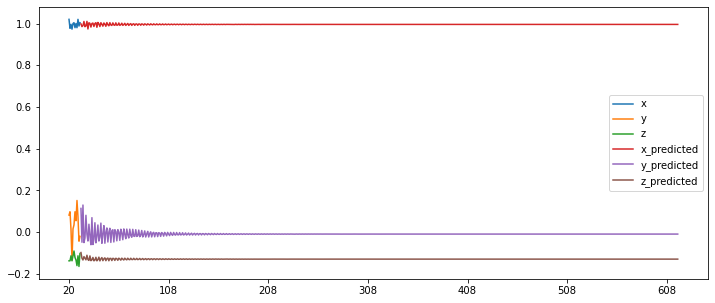

In [17]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)
test_vs_pred.plot(figsize=(12,5))

In [20]:
api_key = "cfbaf0e4-342b-4100-be55-d56d4aac6669"
server_url = 'https://esgf-server-staging.herokuapp.com'
example_id ="FMVnkwoFEuuo9GkN"
prediction="0.972211,0.002333,-0.112556"
service_name = 'predict'
params = f"?api_key={api_key}&example_id={example_id}&prediction={prediction}"
headers = {
       'Accept': 'application/json',
       'Authorization' : f"Bearer {api_key}"
}
response = requests.get(f"{server_url}/{service_name}{params}", headers=headers)
print(response.text)
assert response.status_code == 200

{"rmse_example":0.053697821781449835,"submissions":1,"remaining":499}
